## Notebook example of ptychograpic reconstruction on simulated data

This is a basic example, showing how to:
* simulate data
* compute the object shape from the data
* use the Ptycho operators for reconstruction
* including an incoherent background

In [1]:
# Optional: select language and/or GPU name or rank through environment variable
# import os
# os.environ['PYNX_PU'] = 'opencl'

%matplotlib widget
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from pynx.ptycho import simulation, shape

# Import Ptycho, PtychoData and operators (automatically selecting OpenCL or CUDA)
from pynx.ptycho import *

## Simulate the Ptychography dataset

Simulating object: siemens
Simulating probe: focus
Simulating scan: spiral
Simulating ptychographic data [200 frames].


Parameters of the simulation:
Data info: {'pix_size_direct_nm': 10, 'num_phot_max': None, 'nb_photons_per_frame': 1000000000.0, 'bg': array([[5100.72321037, 5201.32439896, 5303.09412772, ..., 5303.09412772,
        5201.32439896, 5100.72321037],
       [5201.32439896, 5303.90973739, 5407.68666302, ..., 5407.68666302,
        5303.90973739, 5201.32439896],
       [5303.09412772, 5407.68666302, 5513.49410026, ..., 5513.49410026,
        5407.68666302, 5303.09412772],
       ...,
       [5303.09412772, 5407.68666302, 5513.49410026, ..., 5513.49410026,
        5407.68666302, 5303.09412772],
       [5201.32439896, 5303.90973739, 5407.68666302, ..., 5407.68666302,
        5303.90973739, 5201.32439896],
       [5100.72321037, 5201.32439896, 5303.09412772, ..., 5303.09412772,
        5201.32439896, 5100.72321037]]), 'beam_stop_transparency': 0, 'noise': 'poisson', 'wavelengt

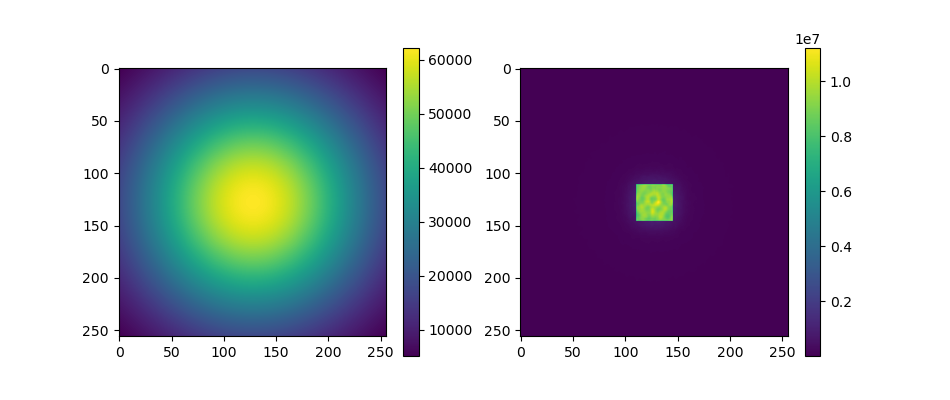

In [2]:
# 2D detector size (square)
nxy = 256
# Pixel size in meters
pixel_size_detector = 55e-6
# Wavelength in meters
wavelength = 1.5e-10
# Detector distance in meters
detector_distance = 1

# background
x,y = np.arange(nxy), np.arange(nxy)
dx, dy = np.meshgrid((x - x.mean()) / (x.max() - x.min()), (y - y.mean()) / (y.max() - y.min()))
bg = np.exp(-5 * (dx ** 2 + dy ** 2))
bg *= 2 * 1e9 / bg.sum()

# Object options 'siemens' simulates Siemens star (with a few holes)
# 'logo' simulates PyNX logo
# obj_info = {'type': 'logo', 'phase_stretch': 1.57, 'alpha_win': .2}
obj_info = {'type': 'siemens', 'phase_stretch': 1.57, 'alpha_win': .2}

# Probe description, either as a Gaussian, or as a focused aperture
probe_info = {'type': 'focus', 'aperture': (150e-6, 150e-6), 'focal_length': .08,
              'defocus': 350e-6, 'shape': (nxy, nxy)}
# probe_info = {'type': 'gauss', 'sigma_pix': (20, 20), 'shape': (nxy, nxy)}

# Spiral scan: 50 positions = 4 turns, 78 = 5 turns, 113 = 6 turns
scan_info = {'type': 'spiral', 'scan_step_pix': 20, 'n_scans': 200}

if False:
    # Use last frame without sample (direct beam ; serves as an absolute reference)
    s = simulation.Simulation(obj_info=None, probe_info=None, scan_info=scan_info, data_info=None, verbose=False)
    s.make_scan()
    posx, posy = s.scan.values
    posx[-1] = 1e20
    posy[-1] = 1e20
    posx = np.ma.masked_array(posx, posx>=1e10)
    posy = np.ma.masked_array(posy, posy>=1e10)
    scan_info = {'type': 'custom', 'x': posx, 'y': posy}

# Data info, with the different parameters and using Poisson noise
# nb_photons_per_frame is the average number of photons per frame
data_info = {'nb_photons_per_frame': 1e9, 'bg': bg, 'wavelength': wavelength,
             'detector_distance': detector_distance,
             'detector_pixel_size': pixel_size_detector,
             'noise': 'poisson'}

# Initialisation of the simulation
s = simulation.Simulation(obj_info=obj_info, probe_info=probe_info, scan_info=scan_info, data_info=data_info)
s.make_data()
posx, posy = s.scan.values
pixel_size_object = wavelength * detector_distance / pixel_size_detector / nxy
ampl = s.amplitude.values  # square root of the measured diffraction pattern intensity


plt.figure(figsize=(9.5,4))
plt.subplot(121)
plt.imshow(bg)
plt.colorbar()

plt.subplot(122)
plt.imshow((ampl**2).mean(axis=0))
plt.colorbar()


## Prepare the initial object and probe
This uses the `pynx.ptycho.simulation` module for an explicit simulation of object and probe.

Note that if the initial object array is not supplied to the `Ptycho`object (`obj=None`), its size will be automatically calculated, and the object initialised to an homogeneous object (array of 1)

In [3]:
# Size of the reconstructed object
nyo, nxo = shape.calc_obj_shape(posx, posy, ampl.shape[1:])

# Initial object
obj_init_info = {'type': 'random', 'range': (0.9, 1, 0, 0.5), 'shape': (nyo, nxo)}

# Initial probe
probe_init_info = {'type': 'focus', 'aperture': (150e-6, 150e-6), 'focal_length': .08,
              'defocus': 250e-6, 'shape': (nxy, nxy)}

# Basic data info, used to compute the object pixel size
data_info = {'wavelength': wavelength, 'detector_distance': detector_distance,
             'detector_pixel_size': pixel_size_detector}
# Perform the actual simulation
init = simulation.Simulation(obj_info=obj_init_info, probe_info=probe_init_info, data_info=data_info)
init.make_obj()
init.make_probe()

Simulating object: random
Simulating probe: focus


## Create the `PtychoData` and `Ptycho` objects

In [4]:
data = PtychoData(iobs=ampl ** 2, positions=(posx * pixel_size_object, posy * pixel_size_object), 
                  detector_distance=1, mask=None, pixel_size_detector=55e-6, wavelength=1.5e-10)

# Random object start + almost no initial background
bg0 = np.random.uniform(0.5,1.5,bg.shape)
p = Ptycho(probe=init.probe.values, obj=init.obj.values, data=data, background=bg0)

# Initial scaling of object and probe
p = ScaleObjProbe(verbose=True) * p

ScaleObjProbe: 3191.7012 328454.38 3681.7558459057846 615.5366360575991 5.981375671012365


## Optimise the Ptycho object 
This can use different algorithms:
* Difference Map
* Alternating Projections
* Maximum Likelihood conjugate gradient

For each algorithm it is possible to update object, probe, positions, and to display the result.

Each algorithm operator is elevated to the the number of cycles, e.g. `DM()**40` will perform 40 cycles

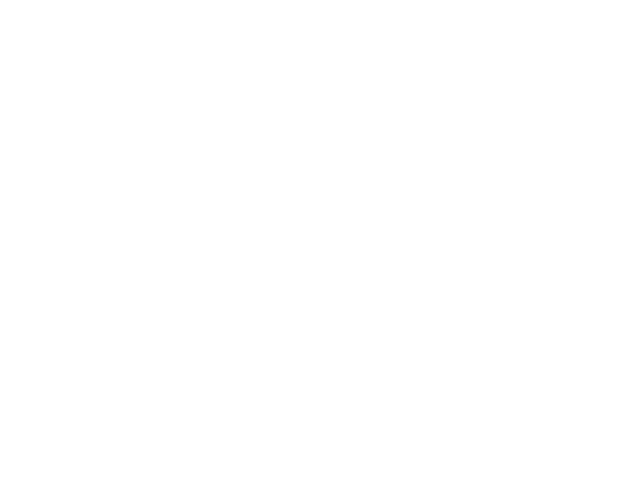

In [5]:
fig = plt.figure()

In [6]:
p = DM(update_object=True, update_probe=True, update_background=1, calc_llk=10, show_obj_probe=10,
      center_probe_n=0)**200 * p
p = AP(update_object=True, update_probe=True, calc_llk=10, update_background=1)**40 * p
#p = ML(update_object=True, update_probe=True, calc_llk=20, show_obj_probe=20, update_background=0)**100 * p

DM/o/p/b   #  0 LLK= 180108.26(p) 166821.19(g) 197903.22(e), nb photons=3.000337e+12, dt/cycle=10.5163s
DM/o/p/b   # 10 LLK=  2466.76(p)  4273.86(g)  4679.02(e), nb photons=2.952238e+12, dt/cycle= 0.0453s
DM/o/p/b   # 20 LLK=   667.47(p)  1154.65(g)  1274.65(e), nb photons=2.999832e+12, dt/cycle= 0.0497s
DM/o/p/b   # 30 LLK=   394.64(p)   690.16(g)   756.91(e), nb photons=3.000209e+12, dt/cycle= 0.0488s
DM/o/p/b   # 40 LLK=   286.57(p)   506.83(g)   551.75(e), nb photons=3.000248e+12, dt/cycle= 0.0562s
DM/o/p/b   # 50 LLK=   222.98(p)   398.90(g)   430.92(e), nb photons=3.000259e+12, dt/cycle= 0.0550s
DM/o/p/b   # 60 LLK=   181.01(p)   326.73(g)   350.80(e), nb photons=3.000265e+12, dt/cycle= 0.0601s
DM/o/p/b   # 70 LLK=   151.22(p)   274.86(g)   293.71(e), nb photons=3.000270e+12, dt/cycle= 0.0617s
DM/o/p/b   # 80 LLK=   129.54(p)   236.57(g)   251.98(e), nb photons=3.000273e+12, dt/cycle= 0.0638s
DM/o/p/b   # 90 LLK=   112.67(p)   206.62(g)   219.45(e), nb photons=3.000275e+12, dt/cy

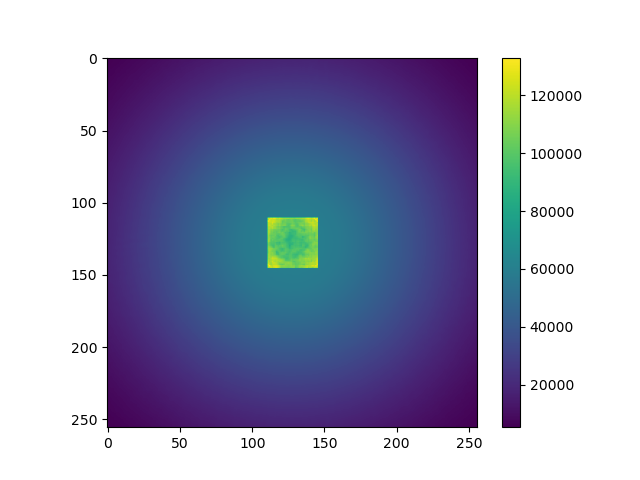

In [7]:
# Look at the reconstructed background

plt.figure()
plt.imshow(p.get_background())  #, norm=LogNorm(vmin=0.5))
#plt.imshow(p.get_background(), norm=LogNorm())
#plt.imshow(abs(p._probe[0]), norm=LogNorm())
plt.colorbar()

## Add probe modes and continue optimising
The `DM/o/3p` indicates:
* the algorithm (DM or AP or ML)
* the parts which are optimised (o for object, p for probe, t for translations)
* the number of modes (when >1)

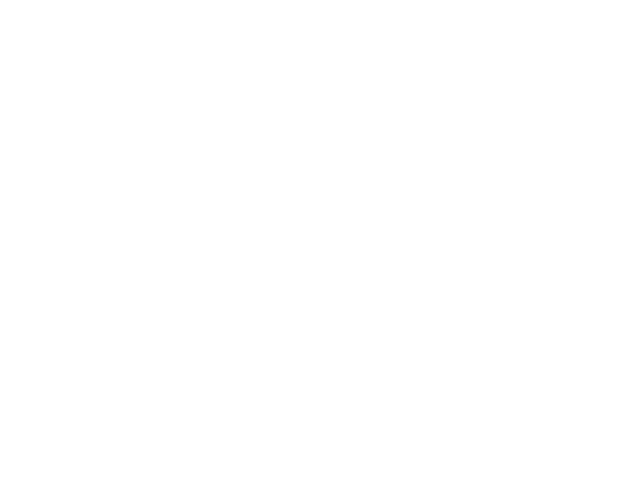

In [8]:
fig = plt.figure()

In [9]:
pr = p.get_probe()
nb_probe, ny, nx = pr.shape
# New number of probe modes
nb_probe = 5  # 35??
pr1 = np.empty((nb_probe, ny, nx), dtype=np.complex64)
pr1[0] = pr[0]
for i in range(1, nb_probe):
    n = abs(pr).mean() / 10
    pr1[i] = np.random.uniform(0, n, (ny, nx)) * np.exp(1j * np.random.uniform(0,2*np.pi, (ny,nx)))

p.set_probe(pr1)

p = DM(update_object=True, update_probe=True, update_background=1, calc_llk=10, show_obj_probe=10)**40 * p
p = AP(update_object=True, update_probe=True, update_background=1, calc_llk=10, show_obj_probe=10)**40 * p
p = ML(update_object=True, update_probe=True, update_background=1, calc_llk=20, show_obj_probe=20)**100 * p


DM/o/5p/b  #240 LLK=    35.21(p)    70.06(g)    70.08(e), nb photons=3.006484e+12, dt/cycle=30.8286s
DM/o/5p/b  #250 LLK=    29.43(p)    54.97(g)    57.63(e), nb photons=3.000288e+12, dt/cycle= 0.0922s
DM/o/5p/b  #260 LLK=    27.45(p)    51.25(g)    53.75(e), nb photons=3.000288e+12, dt/cycle= 0.0927s
DM/o/5p/b  #270 LLK=    25.36(p)    47.50(g)    49.71(e), nb photons=3.000288e+12, dt/cycle= 0.0961s
DM/o/5p/b  #279 LLK=    23.60(p)    44.32(g)    46.30(e), nb photons=3.000288e+12, dt/cycle= 0.1014s
AP/o/5p/b  #280 LLK=    23.42(p)    43.99(g)    45.94(e), nb photons=3.000289e+12, dt/cycle= 0.4678s
AP/o/5p/b  #290 LLK=    21.49(p)    41.23(g)    42.39(e), nb photons=3.000244e+12, dt/cycle= 0.0901s
AP/o/5p/b  #300 LLK=    20.45(p)    39.36(g)    40.37(e), nb photons=3.000250e+12, dt/cycle= 0.0931s
AP/o/5p/b  #310 LLK=    19.59(p)    37.76(g)    38.68(e), nb photons=3.000254e+12, dt/cycle= 0.0967s
AP/o/5p/b  #319 LLK=    18.90(p)    36.47(g)    37.34(e), nb photons=3.000257e+12, dt/cycle

In [10]:
# Manual decompositon of algorithms
#p = Psi2Obj() * PropagateApplyAmplitude()* ObjProbe2Psi() * SelectStack(0) * p
#p = Psi2ObjMerge() * LoopStack(Psi2Obj() * PropagateApplyAmplitude() * ObjProbe2Psi()) * p

## Export data and/or result object & probe to CXI (hdf5) files

In [11]:
if False:
    # 
    p.save_obj_probe_cxi('obj_probe.cxi')
    save_ptycho_data_cxi('data.cxi', ampl ** 2, pixel_size_detector, wavelength, detector_distance,
                         posx * pixel_size_object, posy * pixel_size_object, z=None, monitor=None,
                         mask=None, instrument='simulation', overwrite=True)


## View background
... and test filtering it

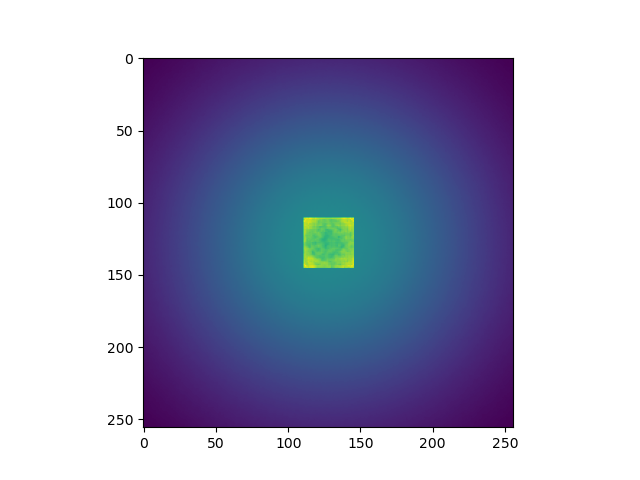

In [12]:
plt.figure()
plt.imshow(p.get_background())  #, norm=LogNorm(vmin=0.5))


In [13]:
b0 = p.get_background()

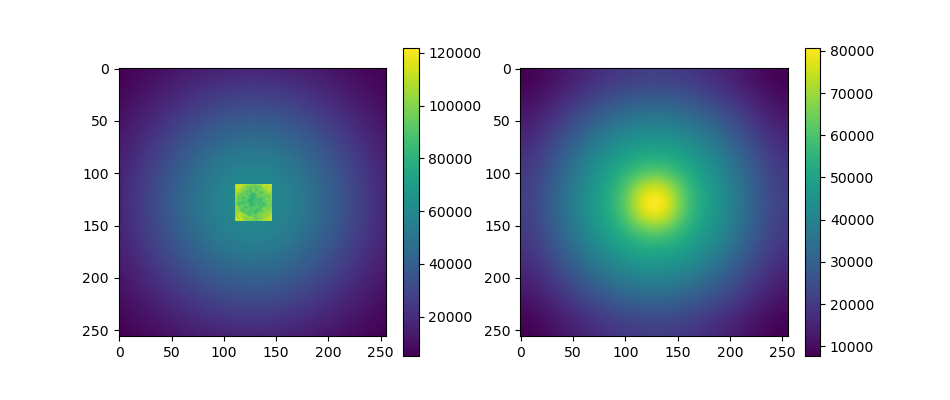

In [14]:
p.set_background(b0)
p = BackgroundFilter(200) * p
b1 = p.get_background()
plt.figure(figsize=(9.5,4))
plt.subplot(121)
plt.imshow(b0)
plt.colorbar()
plt.subplot(122)
plt.imshow(b1)
plt.colorbar()
